### 0. Imports

In [109]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.data_visualization_support as dvs

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Functions under construction

In [110]:
def extract_value(col, key):
    # check if row is str. If it is parse as dict and extract key
    return col.apply(
        lambda x: literal_eval(x).get(key) if isinstance(x, str) else np.nan
    )


def association_matrix(df,method):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    coefficients = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                p_values.loc[col1, col2] = 0  # Diagonal is 0
                coefficients.loc[col1, col2] = 1 # Diagonal is 1
            else:
                coeff, p_value = method(df[col1], df[col2])
                p_values.loc[col1, col2] = p_value
                coefficients.loc[col1, col2] = coeff
    return coefficients, p_values

# 1. Introduction - Madrid rental prices - Exploration

After the cleaning phase in `notebooks/0_cleaning.ipynb`, it is time of exploring the distributions of features and their relationships with respect to the target and other features.

### 1.1 Data import

In [111]:
pd.set_option("display.max_columns",40)
rent_df = pd.read_csv("../datos/cleaned/rent_df_cleaned_v1.csv", index_col=0)
rent_df.head()

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,description,hasLift,parkingSpace_included_in_listing,municipality,province,floor
0,33,550.0,chalet,371.0,False,6,3,40116,1.482480,False,False,False,UGENA VILLAGE INMOBILIARIA GESTIONA en exclusi...,False,False,Numancia de la Sagra,Toledo,NaN
1,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,False,False,LOFT DE DISEÑO. Orientación Este. Muy soleado ...,True,False,Madrid,Madrid,3.0
2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,"Estupendo piso muy iluminado, recientemente re...",False,False,San Sebastián de los Reyes,Madrid,0.0
3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,"A estrenar ático con piscina en Calle Madrid, ...",False,False,Villamanrique de Tajo,Madrid,2.0
4,22,450.0,flat,89.0,False,2,1,47186,5.056180,False,False,False,REDPISO alquila esta vivienda situada en el mu...,True,True,Recas,Toledo,2.0


# 2. EDA

### 2.1 Madrid rental units

Although the purpose of this project is to predict Madrid's rental prices, there is data from different provinces and also different municipalities. Therefore, we will continue ahead with all the data and assess through EDA whether to:
- Drop provinces other than Madrid
- Drop municipalities other than Madrid
- Create 2 models: 1. Madrid and 2. Other municipalities

### Custom questions to answer during EDA

Appart from the unavoidable questions about univariate feature distribution and feature relationships

**Geography of study**

Should I just keep appartments in Madrid? Or just in the municipality of madrid?

**Category representation**

What cateogries should be grouped? Should some be left out?
- PropertyType: Make groupings? Leave out underrepresented categories? 

**Description data extraction**

Are there useful characteristics in the description field?

**Interaction between lift, floor and price**

**Distance as price informative**

Is it a good measure to inform price? Could we use latitude and longitude to get better proxies such as facilities around (schools, supermarkets, activites, etc), median income of the district/street or living desirability levels of the surrounding area.

## 2.2 Univariate distributions

In [112]:
visualizador = sp.Visualizador(rent_df.drop(columns=["description"]))

### 2.2.1 Numerical features

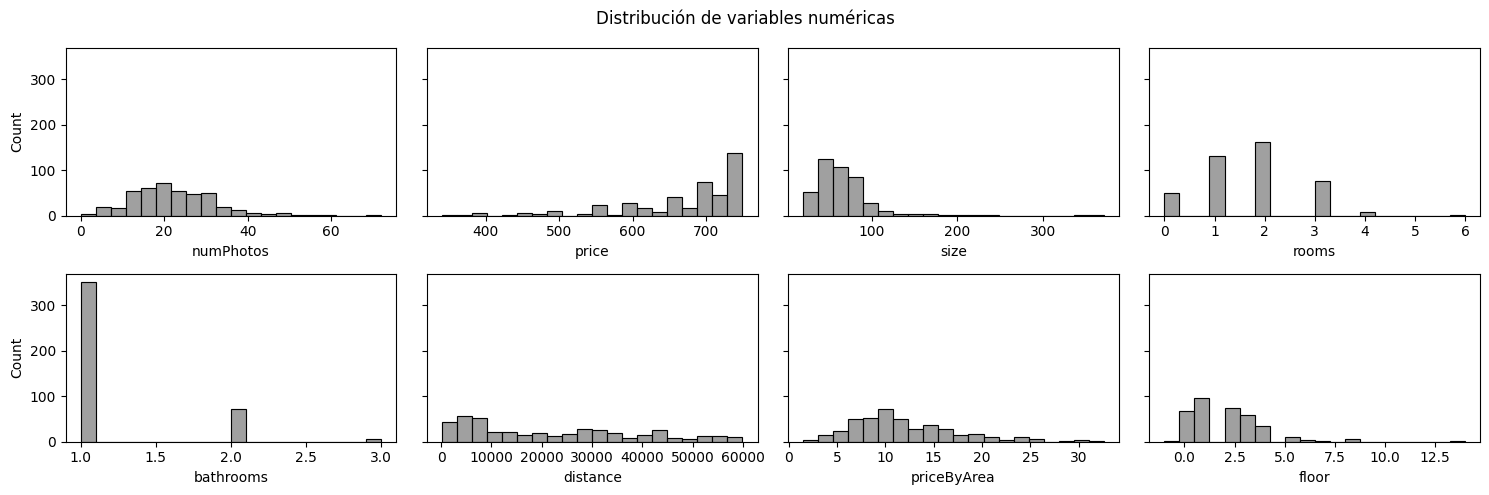

Descriptive statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
numPhotos,428.0,21.885514,9.735542,0.00000,15.000000,21.000000,28.000000,72.000000
price,428.0,672.696262,84.996494,340.00000,640.000000,700.000000,740.000000,750.000000
size,428.0,67.796729,36.362411,20.00000,46.000000,61.500000,80.000000,371.000000
rooms,428.0,1.693925,0.985735,0.00000,1.000000,2.000000,2.000000,6.000000
bathrooms,428.0,1.193925,0.429869,1.00000,1.000000,1.000000,1.000000,3.000000
distance,428.0,22294.946262,17206.150901,183.00000,6991.000000,19631.500000,35166.000000,59919.000000
priceByArea,428.0,12.039732,5.472127,1.48248,8.018519,10.769413,14.705882,32.608696
floor,355.0,1.956338,1.760420,-1.00000,1.000000,2.000000,3.000000,14.000000


In [113]:
visualizador.plot_numericas()
plt.show()

print("Descriptive statistics of numerical features:")
rent_df.drop(columns=["description"]).describe().T

**Target feature - price**
Follows a heavily left-skewed distribution, where prices tend to concentrate on the higher end. A 75% of rental units cost between 640 and 750 euros, a 25% percent (included in prior's 75%) costs between 740 and 750.

**numPhotos**
Follows a seemingly normal distribution, except for a long right tail.

**size**
It's distribution looks like a heavily right skewed normal or log-normal distribution. 50% of prices revolve around the 46-80 square meters mark.

**distance**
This feature shows an odd distribution, with a small percentage of prices concentrating before the 10,000 meters mark and the remaining ones following  a seemingly uniform distribution. This is probably caused by the distance with respect to km.0 for other municipalities.

**pricebyarea**
Follows what seems to be a platykurtic distribution with a heavy right tail. Most prices revolve around the 10 euro per square meter mark.

### 2.2.2 Categorical features

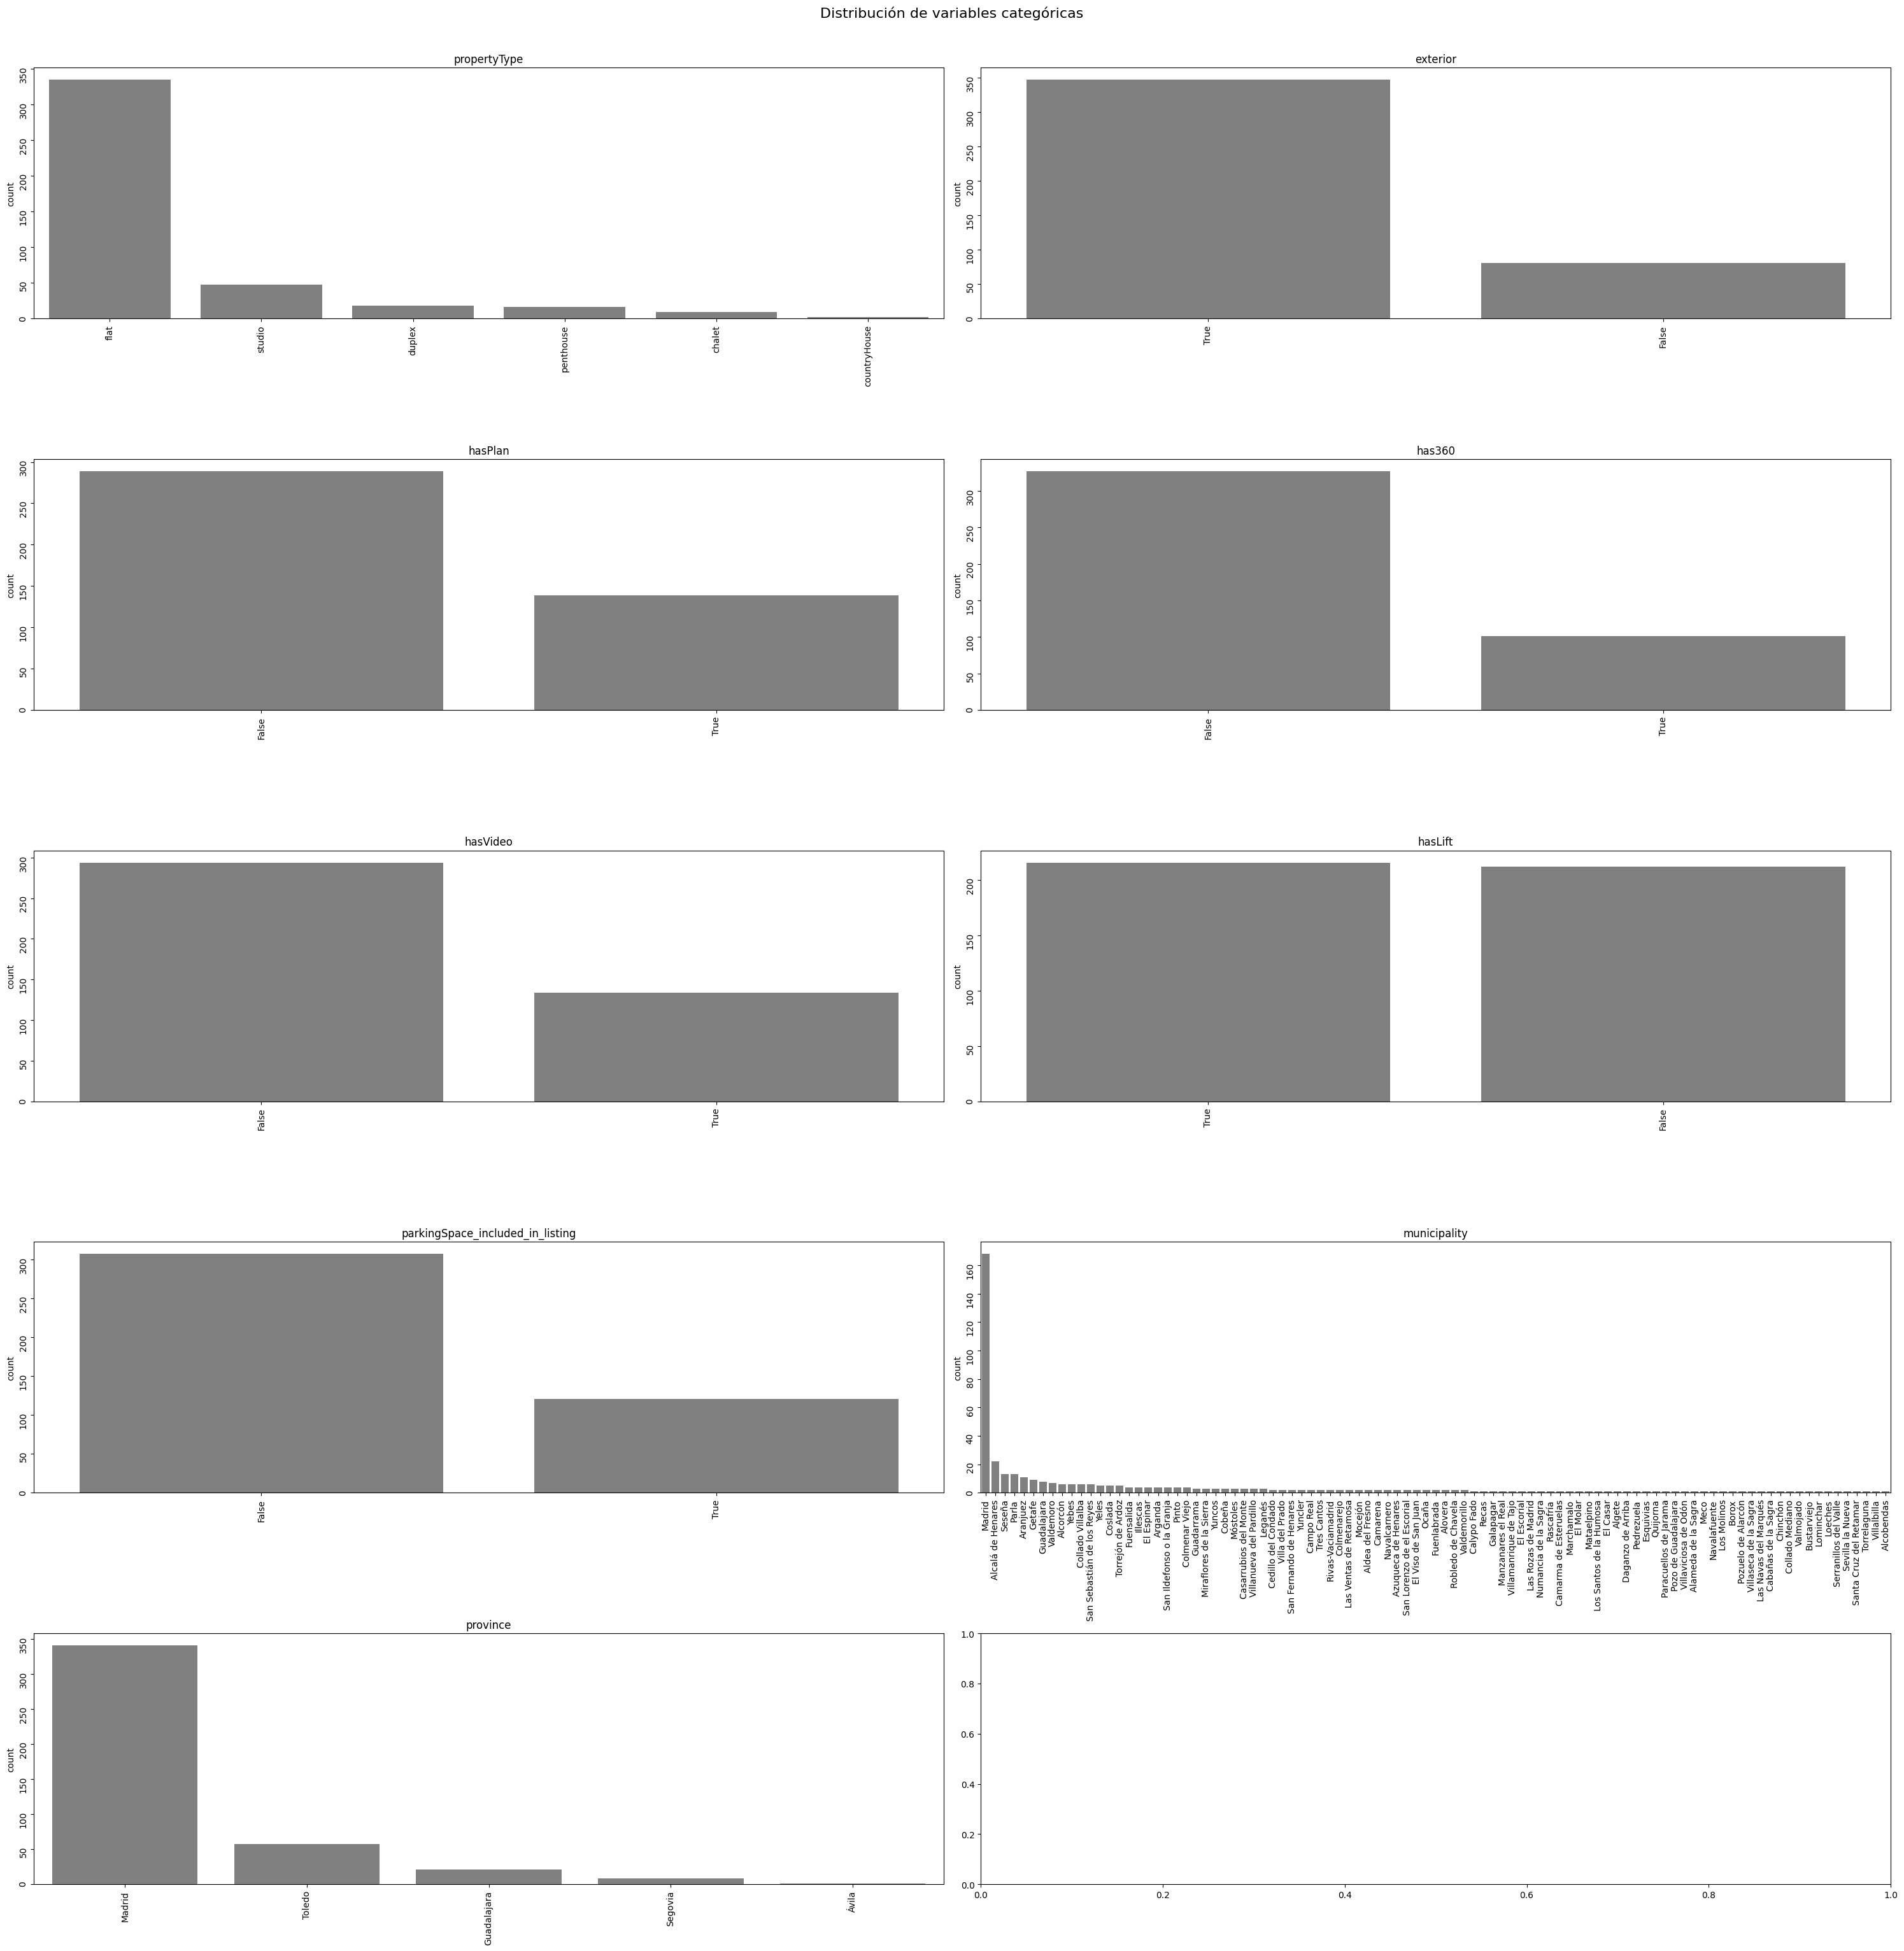

In [114]:
visualizador.plot_categoricas(tamano_grafica=(30, 30))

**propertytype**

The most frequent is the flat, followed by studios, duplex, and penthouse, which are basically variations of this one. Chalet and country house differ a lot from these types of housing and do not posses enough representation, so they will have to probably be dropped.

Besides, all of these properties lie outside the municipality of Madrid's limits. Given the fact that they differ from the main distribution in characteristics and municipality and their low representation, it is fair to drop them. Also, note that all of these rental units count with a lift, which does not make much sense. Therefore, the informational value of this column is to be taken with a grain of salt.

In [115]:
display(rent_df.loc[rent_df["propertyType"].isin(["chalet","countryHouse"]),["municipality","hasLift"]])

# dropping chalets and countryhouses
print(f"Shape before dropping {rent_df.shape[0]}")
rent_df = rent_df[~rent_df["propertyType"].isin(["chalet","countryHouse"])]
print(f"Shape after dropping {rent_df.shape[0]}")

,municipality,hasLift
0,Numancia de la Sagra,False
23,Aldea del Fresno,False
64,Marchamalo,False
162,Los Santos de la Humosa,False
237,Mocejón,False
264,Yeles,False
296,Meco,False
317,Villaviciosa de Odón,False
371,Camarena,False
406,Santa Cruz del Retamar,False


Shape before dropping 428
Shape after dropping 417


**rooms**

Most flats have 1 to 3 rooms. A minority of flats have 4 or 6 rooms, but given their low representation they will be grouped to 4 or more.

In [116]:
rent_df["rooms"].value_counts()

rooms
2    160
1    131
3     71
0     49
4      6
Name: count, dtype: int64

In [117]:
rent_df["rooms"] = np.where(rent_df["rooms"] >= 3, 3, rent_df["rooms"])

**bathrooms**

Most properties have 1 or 2 bathrooms, 3 being unfrequent. Let's check its category representation.

In [118]:
rent_df["bathrooms"].value_counts()

bathrooms
1    348
2     67
3      2
Name: count, dtype: int64

With just 2 rental units of 3 bathrooms, this category can be grouped within the 2 category.

In [119]:
rent_df["bathrooms"] = np.where(rent_df["bathrooms"] >= 2, 2, rent_df["bathrooms"])

**province**

There are provinces outside Madrid. Given that the purpose of the project is to predict rental housing prices in Madrid, although uncler if within the province or the municipality, it is quite clear that houses outside the province lie well outside the scope of the project and without an even representation. Therefore, those categories are dropped, along with the column:

In [120]:
rent_df = rent_df[rent_df["province"] == "Madrid"]
print(f"Shape after dropping other provinces {rent_df.shape[0]}")
rent_df.drop(columns="province",inplace=True)

Shape after dropping other provinces 337


**municipality**

The most frequent is Madrid, with a lot of diverse other options. This is why a second municipality feature has been created for it, being either 'Madrid' or 'Other' municipality. Perhaps a better predictor for price for non 'Madrid' municipalities is the distance with respect to the city centre km.0 or wether they are surrounding cities of the M-40/50. 

Due to it's high cardinality this column cannot be used as such.

**floors**

Most floors go from 0 to 4. Beyond 4, they are being grouped inside '4 or more'. There are basement rental units with very low representation. Given that they do not represent what one would consider normal for flats, they could be left out of the study. For now, we will join them to the 0 floor.

In [121]:
display(rent_df.floor.value_counts())

rent_df[rent_df["floor"].isin([-1,-0.5,0])].sort_values("floor").head(4)

floor
 1.0     68
 0.0     58
 2.0     56
 3.0     47
 4.0     32
 5.0      9
 0.5      6
 8.0      4
 6.0      2
-1.0      1
 7.0      1
 14.0     1
-0.5      1
Name: count, dtype: int64

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,description,hasLift,parkingSpace_included_in_listing,municipality,floor
46,20,750.0,flat,30.0,False,1,1,2133,25.000000,False,False,False,"-ZONA IBIZA- Piso reformado de 30m², amueblado...",True,False,Madrid,-1.0
330,17,720.0,flat,44.0,True,1,1,3589,16.363636,True,False,False,! OPORTUNIDAD! REFORMADO! y ECONÓMICO! Semisót...,False,False,Madrid,-0.5
24,12,700.0,flat,105.0,True,3,2,44003,6.666667,False,False,False,NaN,False,False,Aranjuez,0.0
2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,"Estupendo piso muy iluminado, recientemente re...",False,False,San Sebastián de los Reyes,0.0


In [122]:
rent_df["floor_grouped"] = np.where(rent_df["floor"].astype(float) >= 4, 
                                    # then
                                    "4", 
                                    # else
                                    np.where(rent_df["floor"].astype(float) <= 0, 0, rent_df["floor"]))

rent_df["floor_grouped"].fillna("unknown",inplace=True)
rent_df["floor"].fillna("unknown",inplace=True)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_34280\1796258788.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rent_df["floor_grouped"].fillna("unknown",inplace=True)
C:\Users\Miguel\AppData\Local\Temp\ipykernel_34280\1796258788.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

**parkingspace**

Nothing remarkable here.

### 2.3 Multivariate analysis

### 2.3.1 Target price Vs. numerical features

Let's start by identifying important pairwise numerical relationships via a pairplot.

<Figure size 1500x1000 with 0 Axes>

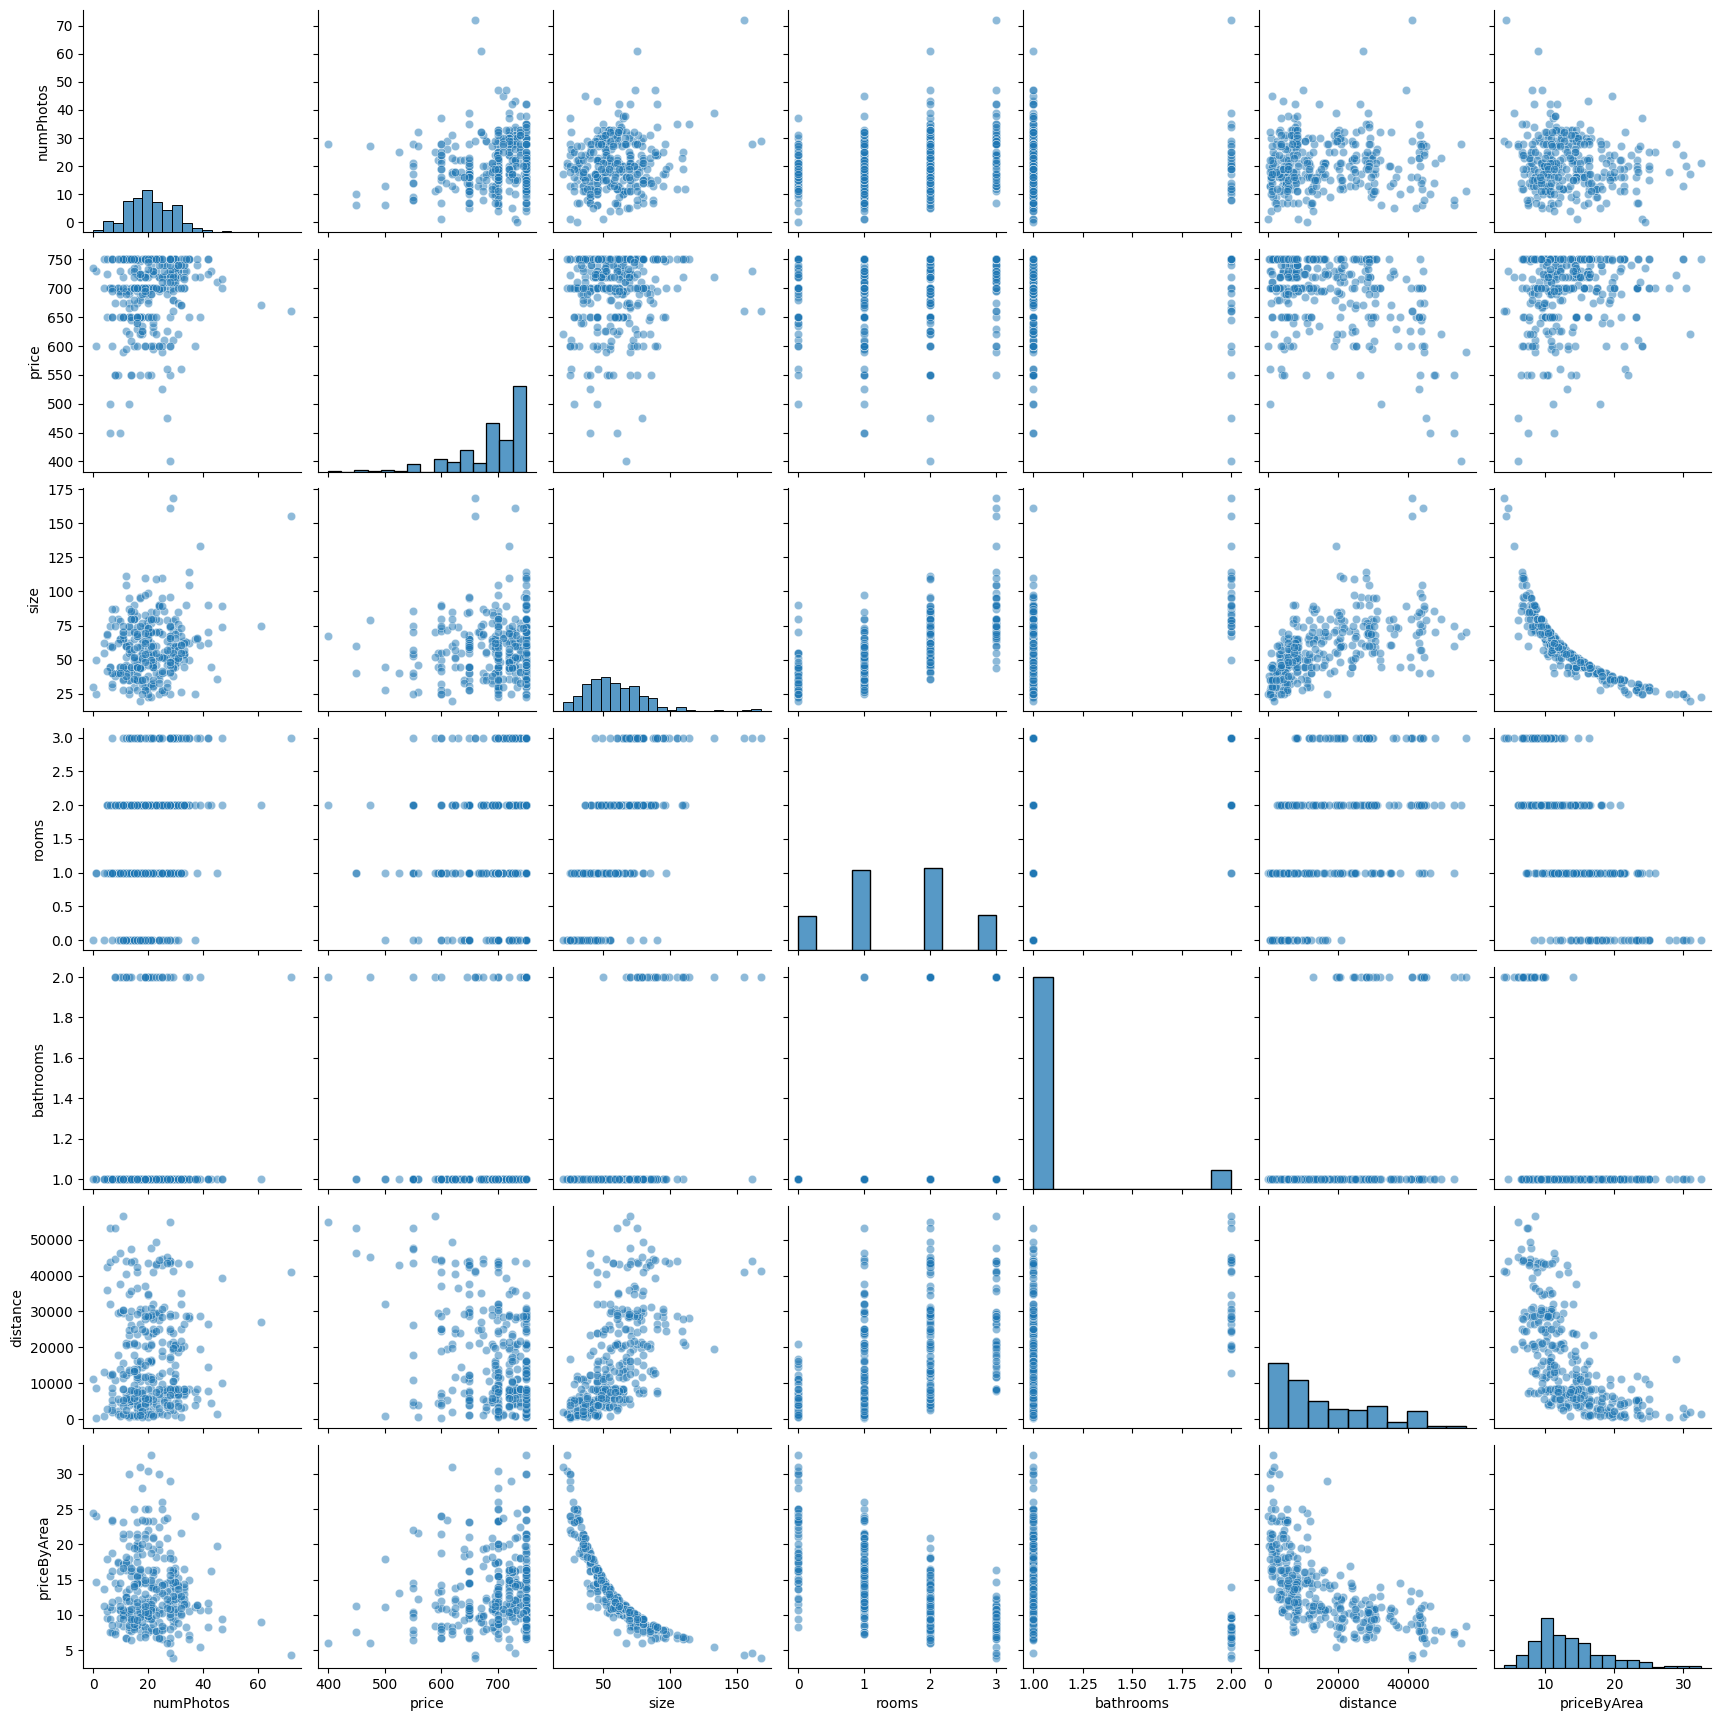

In [123]:
plt.figure(figsize=(15,10))
sns.pairplot(rent_df.select_dtypes(np.number), plot_kws={'alpha': 0.5})
plt.show()

**With respect to target 'price'**
- Numphotos: There is a weak trend to the mean of number of photos uploaded with respect to the price. This can make sense as anyone who has been looking for a house knows that good houses tend to have more quality photos and bad houses tend to have very few or none. Even if the house is not that good, making the effort of creating a good presentation increases value.
- Size: Similar but even weaker relationship than numphotos.
- Distance: Does not show a clear shape. For somepoints as distances increase, price decreases. For some others, concentration of points around high prices increases, similar to the size relationship, quite possibly due to their interaction.
- Pricebyarea: Shows a weak trend of points concentrating more around high prices as the price by area increases. It seems more like there is a ceiling for small prices by area to have high total price, which makes sense as it is limited by the minimum size in square meters a house must have.

**Other relationships**
- Distance to size: Positive correlation pointing to an increase in rental unit size as distance with respect to the city centre increases.
- Distance to priceByArea: As distance increases, there is an exponential decrease in pricebyarea.
- Size to pricebyarea: Almost perfect negative exponential relationship, as pricebyarea is a column derived from size and price. However, it looks like this feature has "cleaner" relationships with distance for instance. It could make sense to use this feature as a target instead.

Relationships with respect to 'price are not quite clear and the presence of a few outlying points can skew the measurements, so instead of pearson's correlation we will use spearman's to check for correlations.

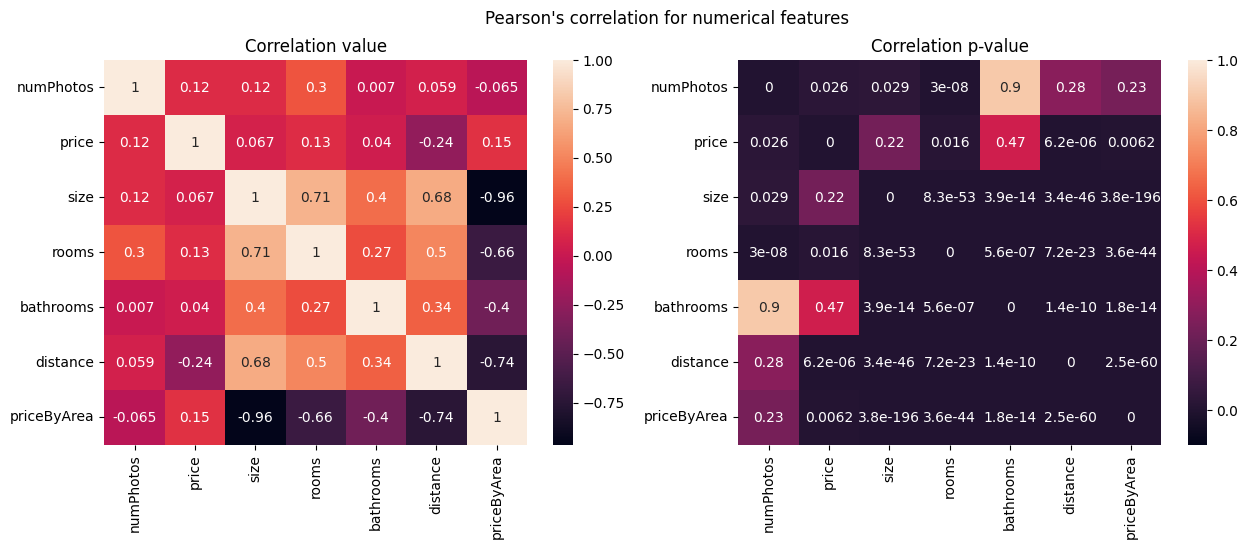

In [124]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flat

fig.suptitle("Pearson's correlation for numerical features")

axes[0].set_title("Correlation value")
sns.heatmap(rent_df.select_dtypes(np.number).corr(method="spearman"),annot=True, ax=axes[0])

axes[1].set_title("Correlation p-value")
p_matrix = association_matrix(rent_df.select_dtypes(np.number), method=spearmanr)[1].astype(float)
sns.heatmap(p_matrix, annot=True, ax=axes[1], vmin=1, vmax=0)
plt.show()

**With respect to target 'price'**
- Distance is found to have the biggest significant correlation effect. It is surprising as one would not say it shows the clearest of relationships. It should be studied how well it performs for houses inside Madrid Vs. 'Other' municipalities.
- numphotos is found to be a significant correlation with a small effect. Although it could be spurious, it has been stated that it could have a speculative or marketing-ish effect in price or be a sign of a house being in good shape.
- Size is not found to be a significant correlation, however, this could be due to the necessary interaction with priceByArea. 
- PriceByArea: Shows a small but significant effect. However, it cannot be used as predictor due to the data leakage it creates. It CAN however, be used as a new target, as it is just a linear product of two features (price and the reciprocal of size) but holds stronger relationships with other features.

**Other relationships**
- Distance to size: Confirms positive correlation pointing to an increase in rental unit size as distance with respect to the city centre increases.
- Distance to priceByArea: Confirms negative relationship.
- Size to pricebyarea: Almost perfect negative exponential relationship, as pricebyarea is a column derived from size and price.


### 2.3.2 Target price Vs. binary features

It is now interesting to check an association coefficient of binary features with regards to the numerical target feature using point biserial correlation.

<Axes: >

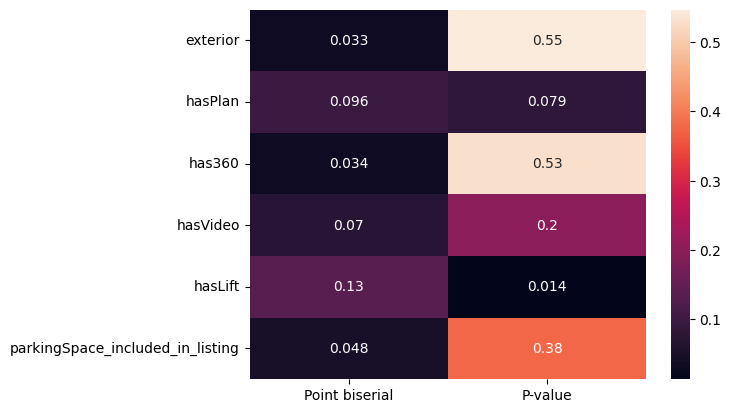

In [125]:
pb_corr_target = {"Point biserial": [],
                  "P-value": []}
for feature in rent_df.select_dtypes(bool):
    correlation, p_value = pointbiserialr(rent_df[feature], rent_df["price"])
    pb_corr_target["Point biserial"].append(correlation)
    pb_corr_target["P-value"].append(p_value)

sns.heatmap(pd.DataFrame(pb_corr_target, index=[feature for feature in rent_df.select_dtypes(bool)]),annot=True)

No variable shows a significant effect with respect to the target except for hasLift. hasLift makes sense a value driver in house pricing, so it can be kept and studied for interactions with other features. Exterior does not show a relevant effect but can also be explored for interactions. HasPlan is completely unknown and it's significance is closest to 0.05 alpha, so it can be kept to be further explored. ParkingSpace_included_in_listing could have an effect in zones of the citycentre, even though it is not shown here. 'hasVideo', 'has360','showAddress', however can be dropped.

If lookig at priceByArea, the image could be different:

<Axes: >

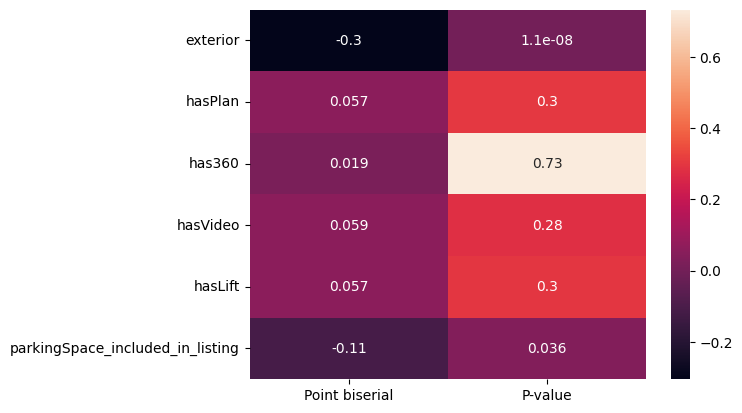

In [126]:
pb_corr_target = {"Point biserial": [],
                  "P-value": []}
for feature in rent_df.select_dtypes(bool):
    correlation, p_value = pointbiserialr(rent_df[feature], rent_df["priceByArea"])
    pb_corr_target["Point biserial"].append(correlation)
    pb_corr_target["P-value"].append(p_value)

sns.heatmap(pd.DataFrame(pb_corr_target, index=[feature for feature in rent_df.select_dtypes(bool)]),annot=True)

Now the picture has changed:
- Exterior was NOT significant for price, but it is for priceByArea.
- hasPlan was close to being significant for price, but it is not for priceByArea.
- hasLift was significant for price, but it is not for priceByArea.
- parkingSpace_included_in_listing was NOT significant for price, but it is for priceByArea.

This goes to show that either priceByArea can be a better predictor for price, or that there is a very important interaction between size and price, that can unlock impact for other features.


The difference in means for the prior columns will now be evaluated alongside the remaining categorical columns to further check for relationships with the target feature.

### 2.3.3 Target price Vs. categorical features

Let's plot the difference in means per category to find if there are meaningful differences among categories that will allow the model to predict better:

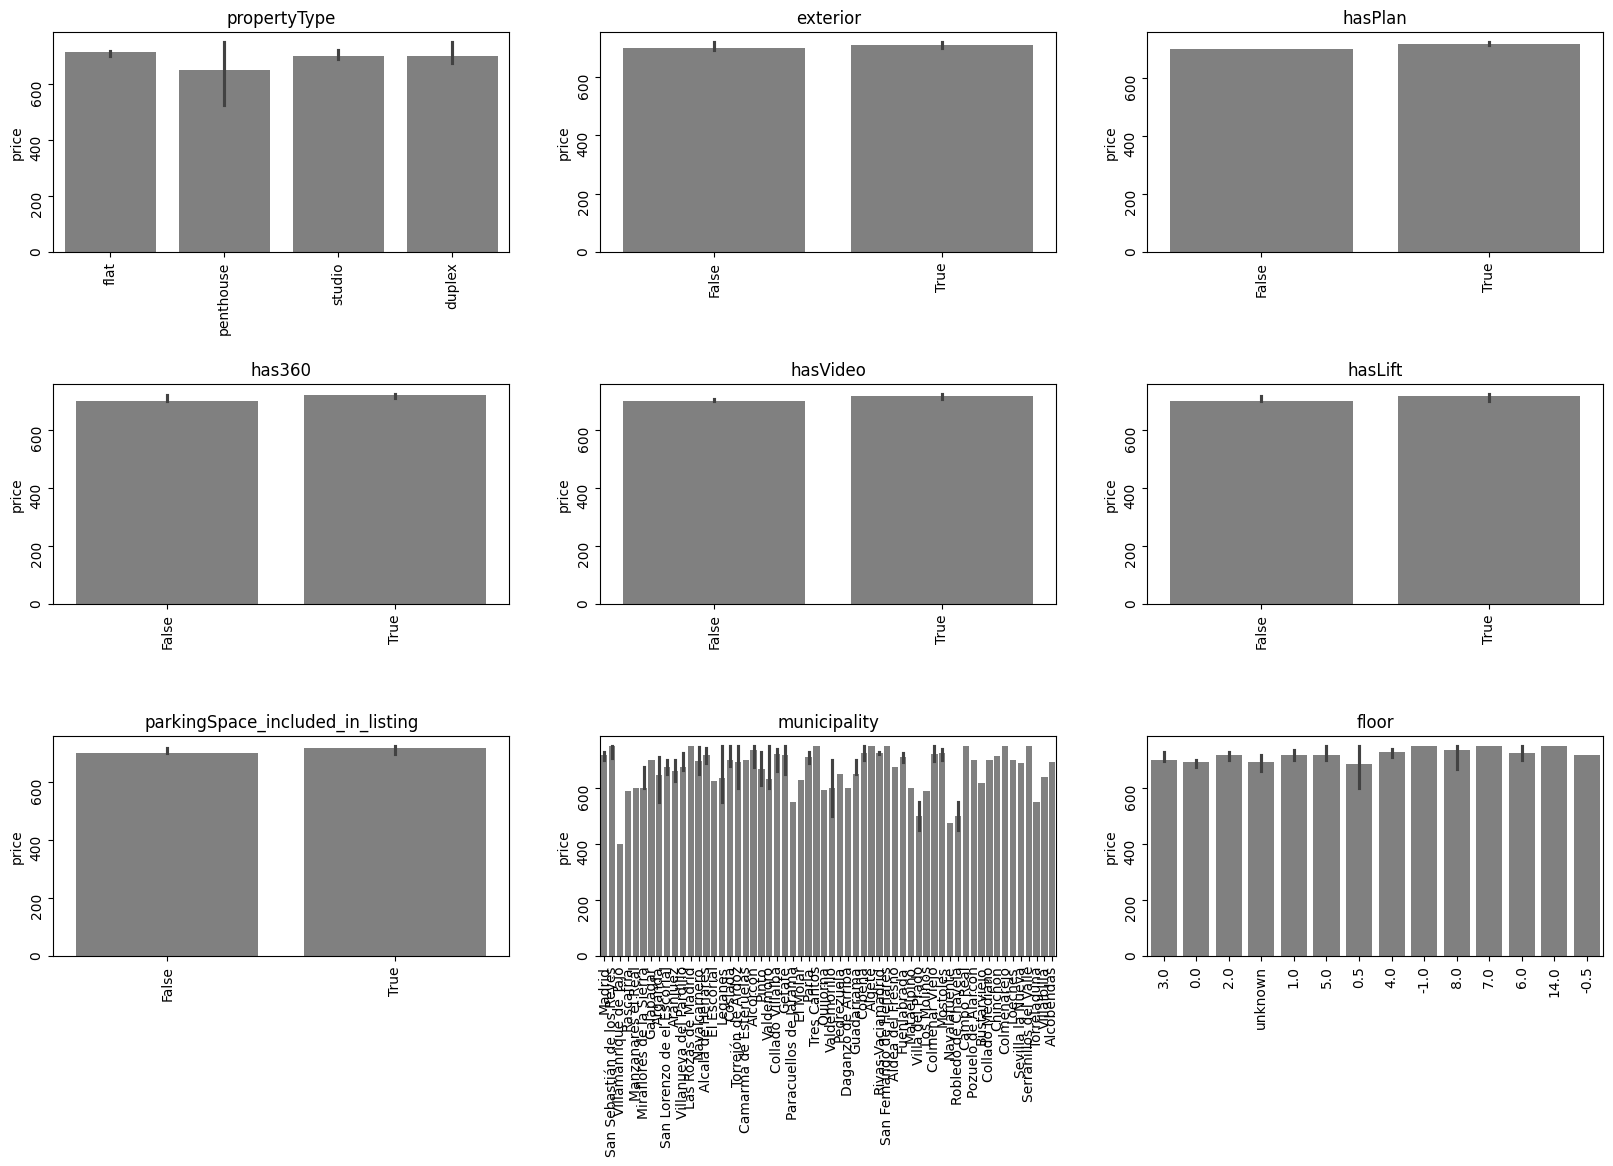

In [127]:
categorical = rent_df.drop(columns=["description"]).select_dtypes(include=["O","category",bool]).columns.to_list() 
categorical_price = categorical + ["price"]
visualizador_categoricas = sp.Visualizador(rent_df[categorical_price])
visualizador_categoricas.plot_relacion("price", tamano_grafica=(20,12))

No big pairwise interaction with respect to the target feature is obtained from the plots. There is perhaps some bigger difference among certain municipalities or districts, however the problem is that their high cardinality cannot be overcome due to their small samples. Therefore, they have to be grouped.

Besides, district is a column with a considerable percentage of missing values, and provides more detailed information about municipality, so the chosen feature among these 2 will be municipality.

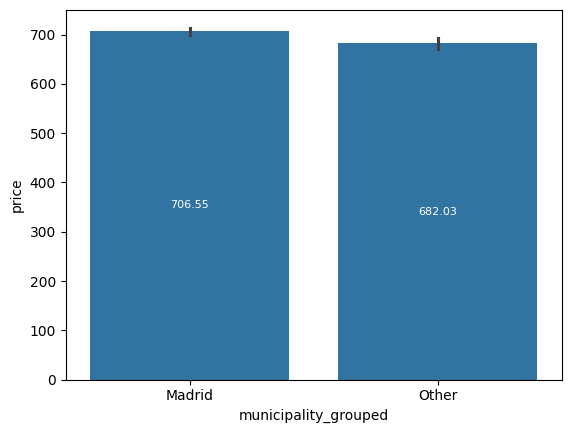

In [128]:
# create munipality grouped column to separate madrid from others
rent_df["municipality_grouped"] = np.where(rent_df["municipality"] == "Madrid", "Madrid","Other")

ax = sns.barplot(data=rent_df,
            x="municipality_grouped",
            y="price")

dvs.plot_bar_labels(ax=ax)

To continue contrasting the impact of the interaction between price and size, let's check the same categorical relationships for priceByArea:

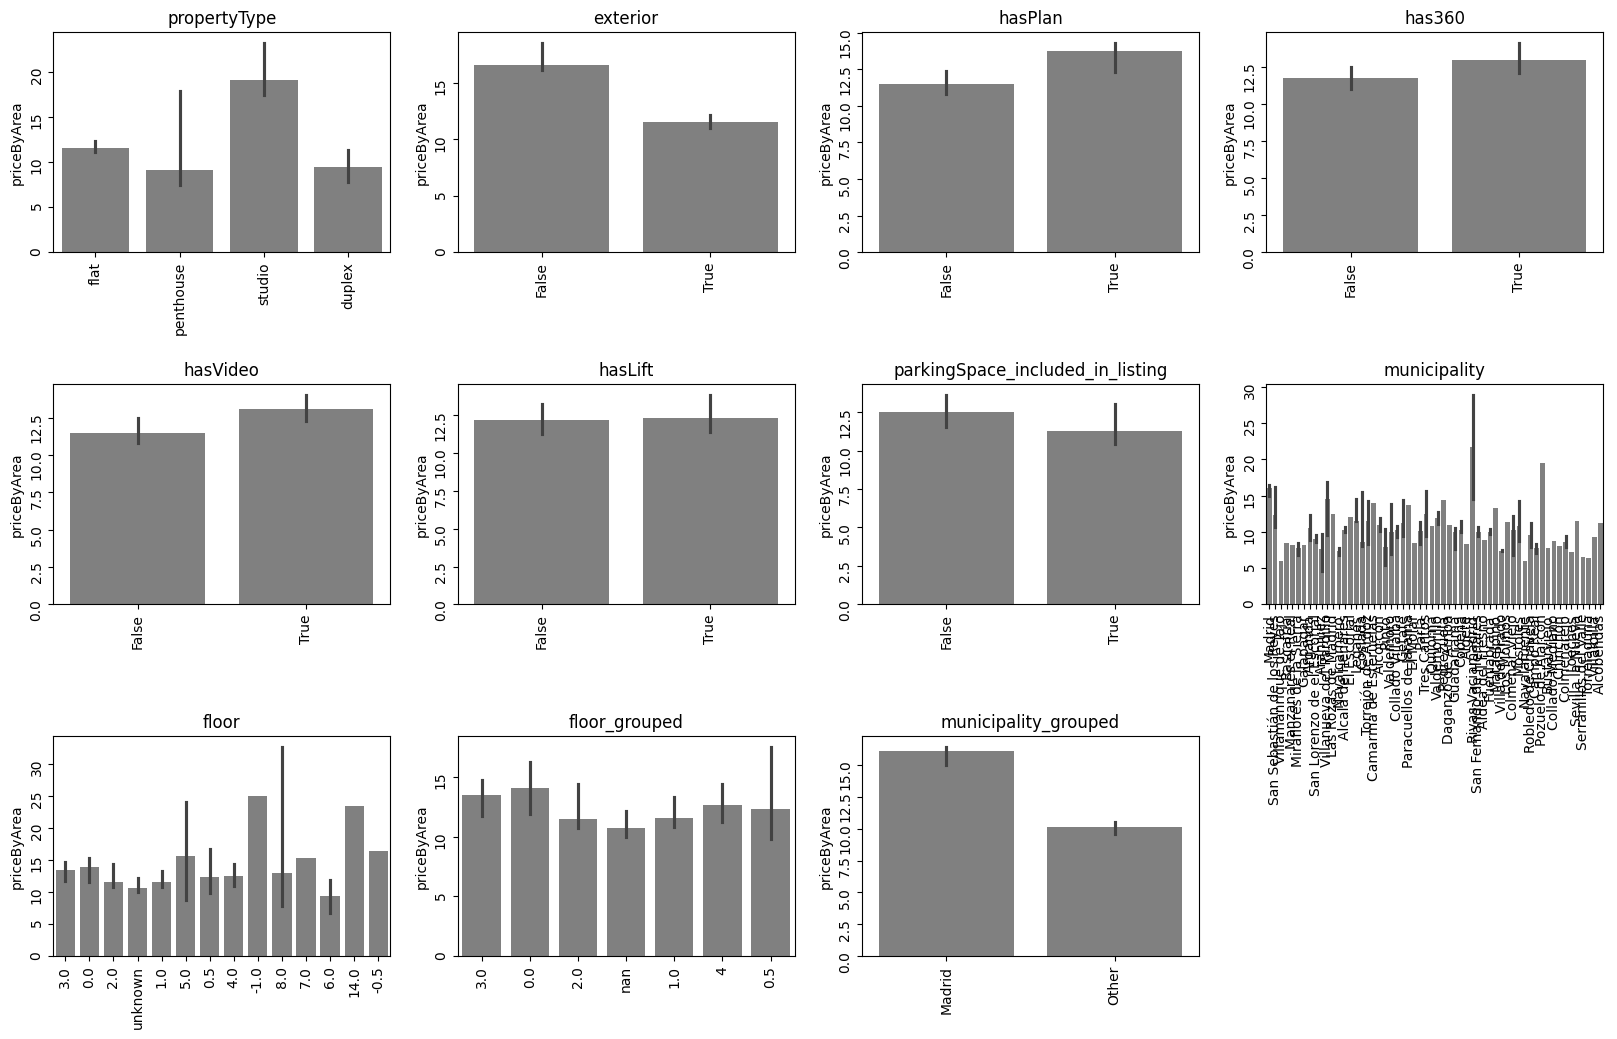

In [129]:
categorical = rent_df.drop(columns=["description"]).select_dtypes(include=["O","category",bool]).columns.to_list() 
categorical_price = categorical + ["priceByArea"]
visualizador_categoricas = sp.Visualizador(rent_df[categorical_price])
visualizador_categoricas.plot_relacion("priceByArea", tamano_grafica=(20,12))

It is much more obvious now that there is indeed a clearer relationship between priceByArea and the categorical features in the dataset that there is with price. This can be interesting to prepare them for encoding.

There is also a bigger difference for municipality_grouped with respect to priceByArea, than there is for price. Let's use this categorical feature to hue the numerical features distributions:

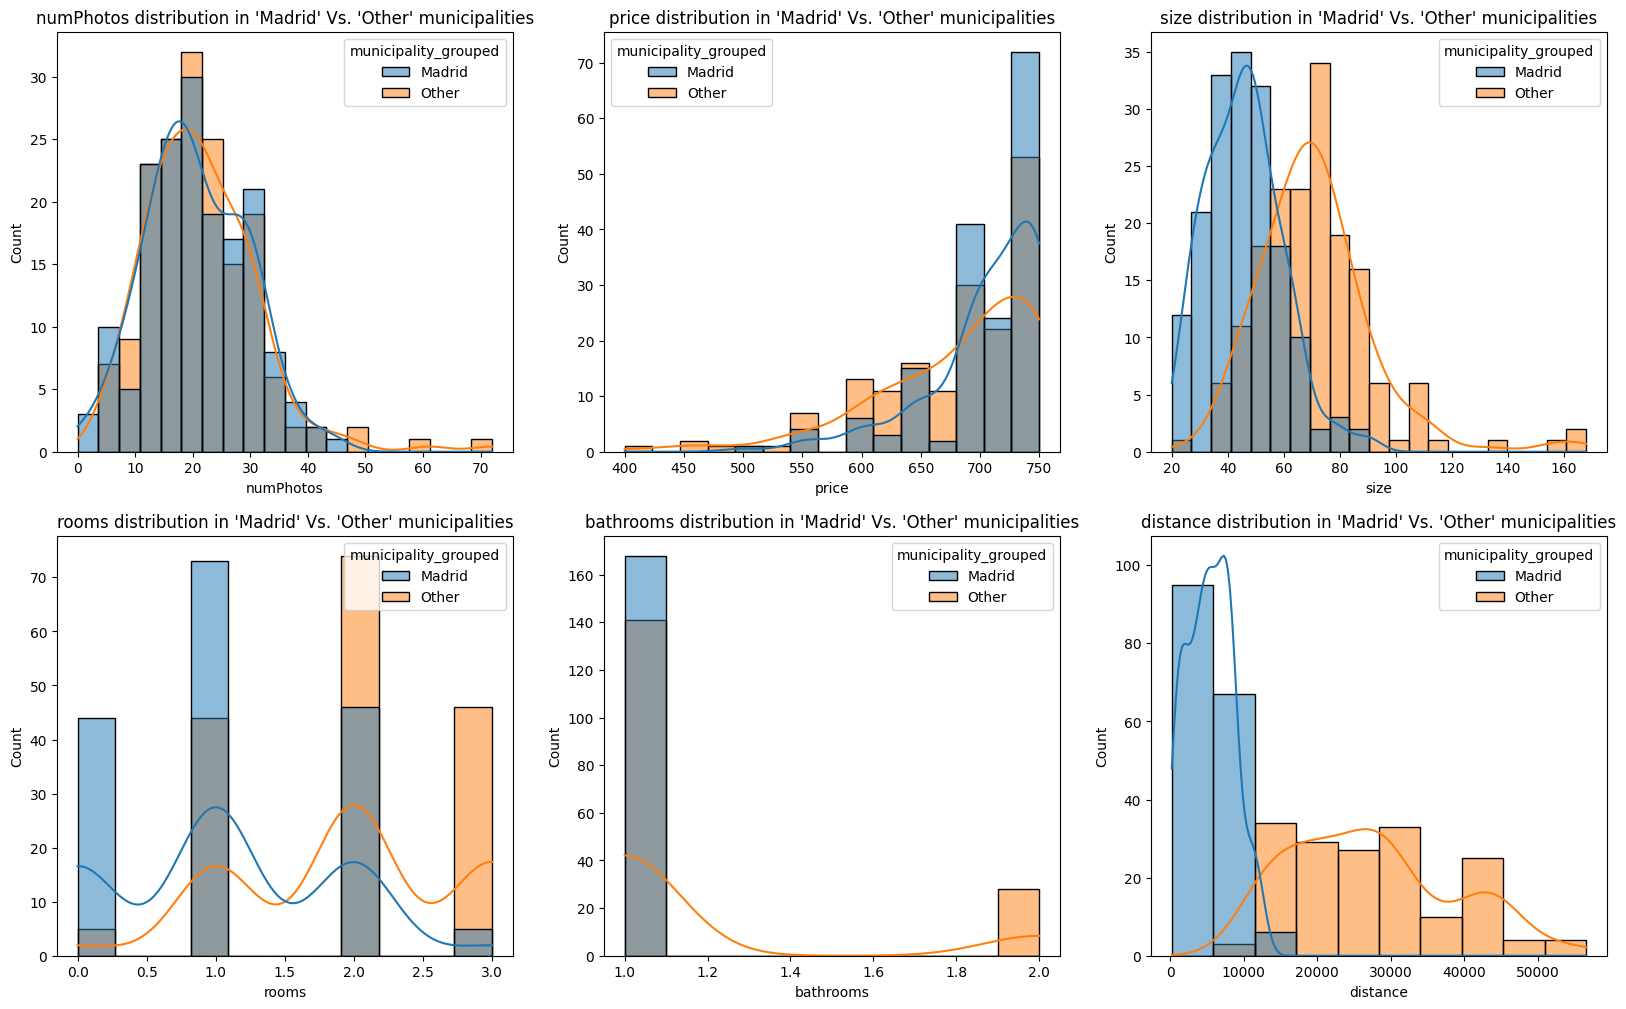

In [130]:
# create munipality grouped column to separate madrid from others
rent_df["municipality_grouped"] = np.where(rent_df["municipality"] == "Madrid", "Madrid","Other")

fig, axes = plt.subplots(2,3, figsize=(20,12))
axes = axes.flat

plt.title(f"Numerical feature distribution for 'Madrid' Vs. 'Other' municipalities")
for ax, column in zip(axes,rent_df.select_dtypes(np.number)):
    ax.set_title(f"{column} distribution in 'Madrid' Vs. 'Other' municipalities")
    sns.histplot(data=rent_df,
                x=column,
                hue="municipality_grouped",
                kde=True,
                ax=ax)

plt.show()

While prices don't change as much, the size of rental units increases as we step out of the municipality of Madrid, this is what makes the distribution of pricesByArea more spread and higher on average there than for other municipalities. Distance with respect to km.0 obviously also increase.

# 3. Export to preprocessing

At this stage, enough EDA has been performed that we can go on a preprocessing and modelling iteration. The current's state dataset will be stripped from, for now, useless columns and will be exported to csv for preprocessing options exploration and then modelling.

In [131]:
rent_df_explored = rent_df[['numPhotos', 'price', 'propertyType', 'size', 'exterior', 'rooms',
       'bathrooms', 'distance', 'priceByArea', 'hasPlan', 'has360', 'hasVideo',
       'hasLift', 'parkingSpace_included_in_listing',
       'floor_grouped', 'municipality_grouped']]

# version for first iteration of preprocessing
rent_df_explored.to_csv("../datos/explored/rent_df_explored_v1.csv")

rent_df.to_csv("../datos/explored/rent_df_explored_full.csv")

### 4. Further EDA (to be taken to another notebook with all the data)